In [222]:
import time

import diffrax
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.lax as lax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optax
from functools import partial

import sys, os
sys.path.append(os.path.join(os.getcwd(), "../"))
from src.data.data_reader import DataReader

key_number = 8

def key():
    global key_number
    key_number += 1
    return jax.random.PRNGKey(key_number)

In [223]:
def get_data(ticker, day, processed_folder="../data/processed"):
    file_path = f"{processed_folder}/{day}.csv"
    df = pd.read_csv(file_path)
    df = df[df["ticker"] == ticker]

    ts = df['ts'].apply(eval).to_list() 
    xs_prices = df['xs_prices'].apply(eval).to_list()
    xs_sizes = df['xs_sizes'].apply(eval).to_list()
    ts_eval = df['ts_eval'].apply(eval).to_list()
    y_test = df['y_test'].apply(eval).to_list()
    
    xs = [list(zip(p, s)) for p, s in zip(xs_prices, xs_sizes)]

    sorted_train_data = []
    for t, x, te, yt in zip(ts, xs, ts_eval, y_test):
        t_datetime = pd.to_datetime(t, unit='ns')
        te_datetime = pd.to_datetime(te, unit='ns')
        t0 = t_datetime[0]
        t_ms = np.array([(ts_i - t0).total_seconds() / 1000 for ts_i in t_datetime])
        te_ms = np.array([(te_i - t0).total_seconds() / 1000 for te_i in te_datetime])
        t_sorted_idx = np.argsort(t_ms)
        t_sorted = t_ms[t_sorted_idx]
        t_unique, unique_t_indices = np.unique(t_sorted, return_index=True)
        te_sorted_idx = np.argsort(te_ms)
        te_sorted = te_ms[te_sorted_idx]
        yt_sorted = np.array(yt)[te_sorted_idx]
        te_unique, unique_te_indices = np.unique(te_sorted, return_index=True)
        yt_unique = yt_sorted[unique_te_indices]
        sorted_train_data.append((t_unique.tolist(), x, te_unique.tolist(), yt_unique.tolist()))
    
    return sorted_train_data


def dataloader(arrays, batch_size, subset_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    
    while True:
        subset_perm = jr.choice(key, indices, shape=(subset_size,), replace=False)
        (key,) = jr.split(key, 1)
        
        start = 0
        end = batch_size
        
        while start < subset_size:
            batch_perm = subset_perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [224]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP  
    def __init__(self, mlp):
        self.mlp = mlp
    def __call__(self, t, y, args):
        return self.mlp(y) 

# NeuralCDE Model
class NeuralCDE(eqx.Module):
    latent_to_latent: eqx.nn.Linear
    func: Func
    control_to_latent: eqx.nn.Linear
    linear: eqx.nn.Linear

    def __init__(self, func, data_size, hidden_size, width_size, depth, *, key):
        lkey, ckey = jax.random.split(key, 2)
        self.latent_to_latent = eqx.nn.Linear(in_features=hidden_size, out_features=hidden_size, key=lkey)
        self.control_to_latent = eqx.nn.Linear(in_features=data_size, out_features=hidden_size, key=ckey)
        self.func = func
        self.linear = eqx.nn.Linear(hidden_size, 1, key=ckey)

    def predict(self, ts, xs, ts_eval):
        def single_sample_prediction(ts_single, xs_single, ts_eval_single):
            ts_interp, xs_interp = diffrax.rectilinear_interpolation(ts_single, xs_single)
            ts_interp = ts_interp[:, None]  
            control_data = jnp.concatenate([ts_interp, xs_interp], axis=-1) 
            control_latent = jax.vmap(self.control_to_latent)(control_data)

            ts_initial = ts_single[None, 0]  
            xs_initial = xs_single[None, 0, :]  
            ts_initial_expanded = ts_initial[:, None]  
            initial_control_value = jnp.concatenate([ts_initial_expanded, xs_initial], axis=-1) 
            y0 = self.control_to_latent(initial_control_value.squeeze(0))  

            saveat = diffrax.SaveAt(ts=ts_eval_single)  
            control = diffrax.LinearInterpolation(ts_interp.squeeze(), control_latent)
            term = diffrax.ControlTerm(self.func, control).to_ode()

            solution = diffrax.diffeqsolve(
                term, diffrax.Tsit5(), t0=ts_single[0], t1=ts_single[-1], dt0=None,
                y0=y0, stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
                saveat=saveat
            )

            return jax.vmap(lambda y: jnn.sigmoid(self.linear(y)))(solution.ys)

        predictions = jax.vmap(single_sample_prediction)(ts, xs, ts_eval)
        return predictions.squeeze()

    def compute_loss(self, ts, xs, ts_eval, y_true):
        y_pred = self.predict(ts, xs, ts_eval)
        return jnp.mean((y_pred - y_true) ** 2)
           

In [225]:
def train(model, train_data, optimizer, steps, batch_size, seq_length, eval_point_ratio, key, subset_size, patience=500, plot_every=500):
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
    losses = []
    best_loss = float('inf')
    best_model = model
    last_best_step = 0
    step_times = []

    @eqx.filter_value_and_grad
    def loss(model, ts, xs, ts_test, y_true):
        return model.compute_loss(ts, xs, ts_test, y_true)

    @eqx.filter_jit
    def make_step(model, opt_state, ts, xs, ts_test, y_true):
        value, grads = loss(model, ts, xs, ts_test, y_true)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return value, model, opt_state
    
    num_params = sum(p.size for p in jax.tree_util.tree_leaves(eqx.filter(model, eqx.is_inexact_array)))
    num_train_points = len(train_data) * seq_length * eval_point_ratio

    print("-" * 60)
    print(f"Number of parameters: {num_params}")
    print(f"Number of data points: {int(num_train_points)}")
    print("-" * 60)

    # Initialize dataloader with subset_size
    ts, xs, ts_eval, y_test = zip(*train_data)
    arrays = (jnp.array(ts), jnp.array(xs), jnp.array(ts_eval), jnp.array(y_test))
    data_gen = dataloader(arrays, batch_size, subset_size=subset_size, key=key)

    for step in range(steps):
        start_time = time.time()

        # Get the next batch from the dataloader
        ts_batch, xs_batch, ts_test_batch, y_true_batch = next(data_gen)

        # Perform a training step
        loss_value, model, opt_state = make_step(model, opt_state, ts_batch, xs_batch, ts_test_batch, y_true_batch)
        losses.append(loss_value)

        step_time = time.time() - start_time
        step_times.append(step_time)
        if len(step_times) > 100:
            step_times.pop(0)

        if loss_value < best_loss:
            best_loss = loss_value
            best_model = model
            last_best_step = step

        if step % 100 == 0:
            avg_step_time = sum(step_times) / len(step_times) if step_times else 0
            estimated_time_remaining = avg_step_time * (steps - step - 1)
            if step == 0:
                print(f"Step {step}, Loss: {loss_value:.4f}, Best Loss: {best_loss:.4f}, Estimated Time Remaining: -- ")
            else:
                print(f"Step {step}, Loss: {loss_value:.4f}, Best Loss: {best_loss:.4f}, Estimated Time Remaining: {estimated_time_remaining / 60:.2f} minutes")

        if step % plot_every == 0:
            _, subkey = jr.split(key)
            random_index = jr.randint(subkey, (1,), 0, batch_size).item()
            plt.figure(figsize=(4, 3))
            plt.plot(ts_test_batch[random_index], y_true_batch[random_index], label='Actual', marker='o')
            y_pred = best_model.predict(jnp.expand_dims(ts_batch[random_index], axis=0), jnp.expand_dims(xs_batch[random_index], axis=0), jnp.expand_dims(ts_test_batch[random_index], axis=0))
            y_pred = y_pred.squeeze()
            plt.plot(ts_test_batch[random_index], y_pred, label='Predicted', marker='x')
            plt.xlabel('Time (ts_test)')
            plt.ylabel('Y values')
            plt.title(f'Training Sequence at Step {step}: Actual vs Predicted Y over Time')
            plt.legend()
            plt.grid(True)
            plt.show()

        if step - last_best_step >= patience:
            print(f"Stopping early at step {step}, no improvement for {patience} steps.")
            return best_model

    plt.figure(figsize=(10, 6))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_model


------------------------------------------------------------
Number of parameters: 275
Number of data points: 10000
------------------------------------------------------------
Step 0, Loss: 168488.0312, Best Loss: 168488.0312, Estimated Time Remaining: -- 


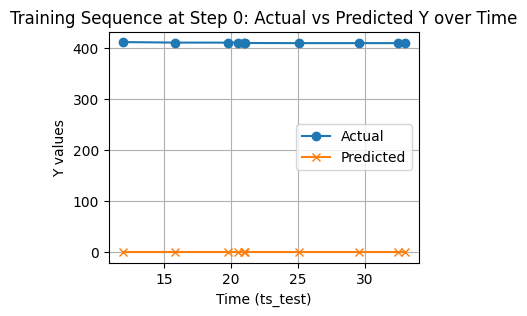

EquinoxRuntimeError: Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "/var/folders/js/9hpr3tt17xd6ttv9xy3zrhw80000gn/T/ipykernel_1008/893851292.py", line 15, in make_step
    value, grads = loss(model, ts, xs, ts_test, y_true)
  File "/var/folders/js/9hpr3tt17xd6ttv9xy3zrhw80000gn/T/ipykernel_1008/893851292.py", line 11, in loss
    return model.compute_loss(ts, xs, ts_test, y_true)
  File "/var/folders/js/9hpr3tt17xd6ttv9xy3zrhw80000gn/T/ipykernel_1008/2164968307.py", line 59, in compute_loss
    y_pred = self(ts, xs, ts_eval)
  File "/var/folders/js/9hpr3tt17xd6ttv9xy3zrhw80000gn/T/ipykernel_1008/2164968307.py", line 55, in __call__
    predictions = jax.vmap(single_sample_prediction)(ts, xs, ts_eval)
  File "/var/folders/js/9hpr3tt17xd6ttv9xy3zrhw80000gn/T/ipykernel_1008/2164968307.py", line 24, in single_sample_prediction
    ts_interp, xs_interp = diffrax.rectilinear_interpolation(ts_single, xs_single)
  File "/Users/erikmjaanes/opt/anaconda3/lib/python3.9/site-packages/diffrax/_global_interpolation.py", line 595, in rectilinear_interpolation
    ts = _check_ts(ts)
  File "/Users/erikmjaanes/opt/anaconda3/lib/python3.9/site-packages/diffrax/_global_interpolation.py", line 407, in _check_ts
    ts = eqxi.error_if(
equinox.EquinoxRuntimeError: `ts` must be monotonically strictly increasing.

-------------------

An error occurred during the runtime of your JAX program.

1) Setting the environment variable `EQX_ON_ERROR=breakpoint` is usually the most useful
way to debug such errors. This can be interacted with using most of the usual commands
for the Python debugger: `u` and `d` to move up and down frames, the name of a variable
to print its value, etc.

2) You may also like to try setting `JAX_DISABLE_JIT=1`. This will mean that you can
(mostly) inspect the state of your program as if it was normal Python.

3) See `https://docs.kidger.site/equinox/api/debug/` for more suggestions.


In [226]:

batch_size = 8
subset_size = 128
train_steps = 2000
x_size = 2
eta = 5e-3
num_train_seq = 1000
train_seq_len = 50
train_test_ratio = 0.2
func_mlp_width = 4
func_mlp_depth = 2
latent_size = 10
num_test_seq = 5
test_seq_len = 200
test_test_ratio = 0.3
train_patience = 200
plot_every = 100

mlp = eqx.nn.MLP(
    in_size=latent_size,
    out_size=latent_size,
    width_size=func_mlp_width,
    depth=func_mlp_depth,
    key=key()
)

func = Func(mlp=mlp)

model = NeuralCDE(
    func=func,
    hidden_size=latent_size,
    width_size=func_mlp_width,
    depth=func_mlp_depth,
    data_size=x_size + 1,
    key=key()
)

optimizer = optax.adam(learning_rate=eta)

train_data = get_data(
    ticker="MSFT",
    day="2024-09-03",
    processed_folder="../data/processed/"
)

trained_model = train(
    model,
    train_data,
    optimizer,
    steps=train_steps,
    batch_size=batch_size,
    seq_length=train_seq_len,
    eval_point_ratio=train_test_ratio,
    key=key(),
    subset_size=subset_size,
    patience=train_patience,
    plot_every=plot_every
)

In [31]:
test_data = get_data(num_sequences=num_test_seq, sequence_length=test_seq_len, test_ratio=test_test_ratio, key=key(),  x_size = x_size)

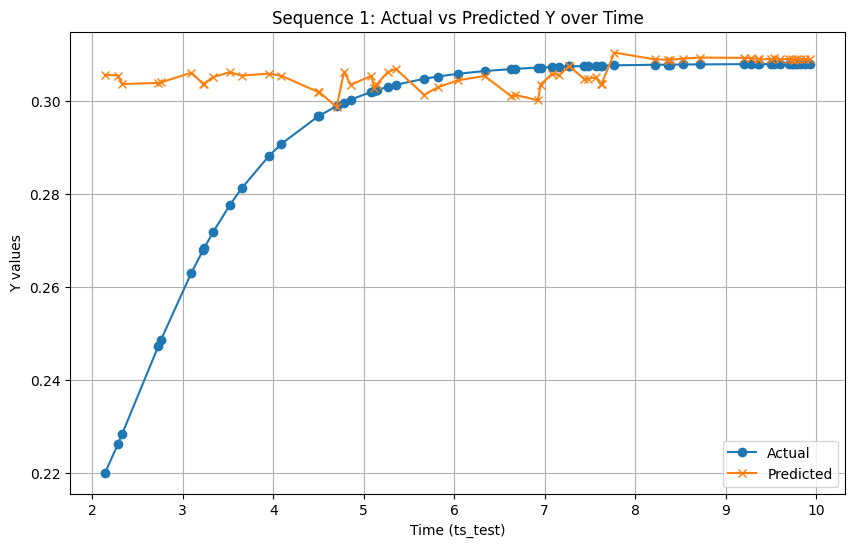

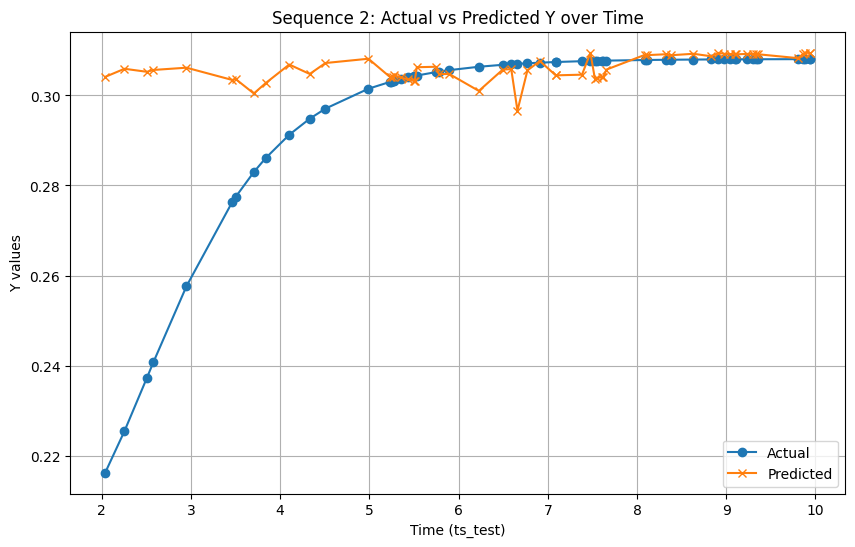

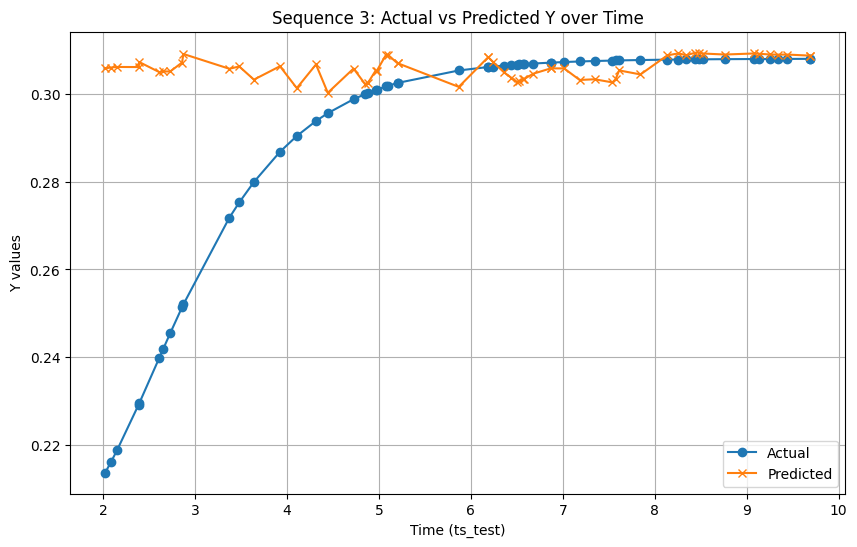

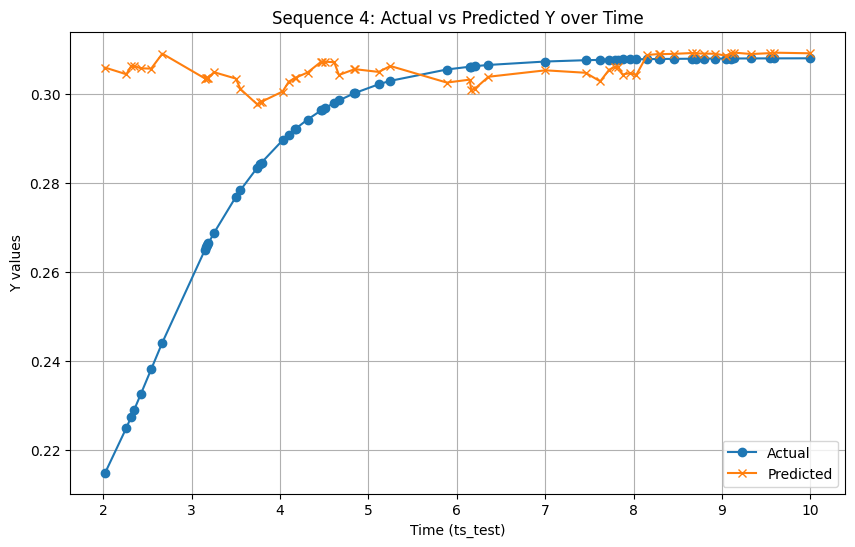

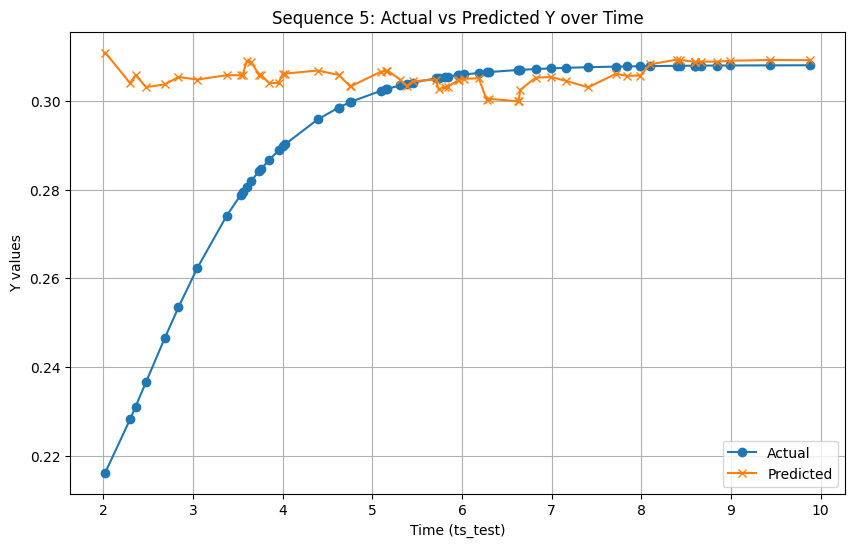

In [32]:
for idx in range(num_test_seq): 
    ts, xs, ts_test, y_true = test_data[idx]
    y_pred = trained_model.predict(jnp.expand_dims(ts, axis=0), jnp.expand_dims(xs, axis=0), jnp.expand_dims(ts_test, axis=0))
    y_pred = y_pred.squeeze()

    plt.figure(figsize=(10, 6))
    plt.plot(ts_test, y_true, label='Actual', marker='o')
    plt.plot(ts_test, y_pred, label='Predicted', marker='x')
    plt.xlabel('Time (ts_test)')
    plt.ylabel('Y values')
    plt.title(f'Sequence {idx + 1}: Actual vs Predicted Y over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

In [33]:
y_pred

Array([0.31088334, 0.30401134, 0.3058207 , 0.30311018, 0.3036959 ,
       0.30537796, 0.3048011 , 0.30577543, 0.30577636, 0.30581942,
       0.3089148 , 0.30876386, 0.30585077, 0.30588034, 0.30406797,
       0.30398434, 0.30608112, 0.306139  , 0.30683726, 0.30584216,
       0.3058434 , 0.3032696 , 0.3033428 , 0.30657682, 0.30677924,
       0.30681866, 0.30477995, 0.30331478, 0.3044272 , 0.3047999 ,
       0.3025881 , 0.3030753 , 0.3032084 , 0.30464667, 0.3046865 ,
       0.3049791 , 0.30508852, 0.30024147, 0.30047387, 0.29988325,
       0.2999174 , 0.30249208, 0.30524784, 0.30535722, 0.30449945,
       0.30305332, 0.30610633, 0.30563363, 0.30571342, 0.3082192 ,
       0.30930412, 0.30925578, 0.30878073, 0.30877933, 0.30877674,
       0.30886474, 0.30882245, 0.30904523, 0.30921325, 0.30917135],      dtype=float32)

In [197]:

train_data = get_data(
    ticker="MSFT",
    day="2024-09-03",
    processed_folder="../data/processed/"
)

In [200]:
len(train_data)

1000

In [204]:
datapoint = train_data[500]

In [205]:
ts, xs, tse, ys = datapoint 

In [206]:
ts

[0.0,
 10971328.979,
 11834689.312,
 13390572.166,
 14134480.748,
 14176095.315000001,
 15618469.317,
 15956418.907,
 16155852.728,
 16904726.435,
 17329017.568,
 17779990.466,
 17969508.188,
 18213701.728,
 18251825.369999997,
 18819599.363,
 18946317.785,
 18991956.290999997,
 19109655.844,
 19837447.046,
 19860694.157,
 20339714.026,
 20861461.728,
 21091672.665,
 21599594.141000003,
 21737682.489,
 21970739.64,
 21988680.253,
 22374246.123,
 23285897.466,
 23425804.033,
 23759458.696999997,
 23898728.483,
 26275131.234,
 29348719.705,
 29663241.761,
 31265705.026,
 31288906.855,
 31495325.847,
 32565766.566999998,
 33206959.6,
 34402813.213,
 34679057.691,
 35730343.927,
 36316785.967,
 36511572.572,
 36527482.227,
 36648265.393,
 36667841.492,
 36760500.415]